Name: Evin Scully

Student Number: 12399266

## Contents of code
1. Pre Analysis/ setup
    1. Importing and Tidying Data
    2. Reshaping Data
    3. Describe Data
2. Composition of sample
    1. Composition of sample
    2. Comparison to Irish population
3. Main Analysis
    1. Check consistency across blocks
    2. Investigate comparison of Total Error to metadata
    3. Scenario question results
    4. Investigate how each graph performed

# Pre Analysis/ setup


Before beginning, the correct packages must be installed

In [1]:
%matplotlib inline
import pandas as pd
import os
import csv
from IPython.display import HTML, display
os.chdir('C:/Users/user/Google Drive/College/- Thesis/20 Results Analysis/Data')
pd.set_option('display.max_columns', None)

import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(sum(map(ord, "aesthetics")))
sns.set_style('ticks')
sns.set_palette('muted')
pal = sns.color_palette('muted').as_hex()
sns.set_context("talk") #  font_scale=1.4

## Importing and Tidying Data

First the survey responses and true values (tv) are imported from .csv files and saved as dataframes. Then the "Block" column is made and labelled appropriately.

The true values are then merged with the appropriate dataframe so as to be easily comparable.

In [2]:
df_tv = pd.read_csv('TrueValues.csv')
df_b1 = pd.read_csv('Block 1 Responses.csv')
df_b2 = pd.read_csv('Block 2 Responses.csv')
df_b3 = pd.read_csv('Block 3 Responses.csv')
df_b4 = pd.read_csv('Block 4 Responses.csv')

df_b1['Block']=1
df_b2['Block']=2
df_b3['Block']=3
df_b4['Block']=4

df_b1 = pd.merge(df_b1, df_tv, how='left', left_on='Block', right_on='block')
df_b2 = pd.merge(df_b2, df_tv, how='left', left_on='Block', right_on='block')
df_b3 = pd.merge(df_b3, df_tv, how='left', left_on='Block', right_on='block')
df_b4 = pd.merge(df_b4, df_tv, how='left', left_on='Block', right_on='block')

Concatenate all the blocks together into one main dataframe (df)

In [3]:
df = pd.concat([df_b1, df_b2, df_b3, df_b4])
df = df.reset_index(drop=True)

Remove the example questions

In [4]:
df.drop(['exp1','exp2','exp3','exp4'], axis=1, inplace=True)

Convert the two angle questions from degrees into percentages

In [5]:
df['angle1'] = df['angle1']/3.6
df['angle2'] = df['angle2']/3.6

Convert the datetime column from a string into a date

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

View a list of all the column headings

In [7]:
list(df.columns)

['timestamp',
 'age',
 'gender',
 'education',
 'device',
 'eyecolour',
 'colourblind',
 'learntype',
 'vistools',
 'scenario1',
 'scenario2',
 'scenario3',
 'scenario4',
 'pie',
 'donut',
 'treemap',
 'bar',
 'stacked',
 'funnel',
 'angle1',
 'angle2',
 'arc1',
 'arc2',
 'area1',
 'area2',
 'comments',
 'confidence',
 'Block',
 'block',
 'pie_tv',
 'donut_tv',
 'treemap_tv',
 'bar_tv',
 'stacked_tv',
 'funnel_tv',
 'angle1_tv',
 'angle2_tv',
 'arc1_tv',
 'arc2_tv',
 'area1_tv',
 'area2_tv']

Create a Total Error field, which is the cumulative sum of the absolute error, per participant.

In [8]:
# First this is set to 0 so that if the cell is reran it doesn't sum again
df['Total_Error'] = 0


# The range 13-25 refers to columns number 13-25 which are the judgement columns.
# So here we are looping throught the columns...
for i in range(13,25):
    
    # ... taking the absolute values (abs) of the judgement minus the true values...
    # (The true values are 16 columns later, hence the +16)
    df['Total_Error'] += abs(df.iloc[:, i] - df.iloc[:, i+16])
    
    # ... And printing one set of true values and judgements for sanity check
    print("guess:",df.iloc[0, i], "true value:",df.iloc[0, i+16])

guess: 17.0 true value: 17.8
guess: 42.0 true value: 38.3
guess: 18.0 true value: 26.1
guess: 7 true value: 10.0
guess: 35.0 true value: 38.6
guess: 15.0 true value: 22.2
guess: 15.277777777777777 true value: 18.2
guess: 12.5 true value: 11.0
guess: 30.0 true value: 30.8
guess: 35.0 true value: 38.6
guess: 20.0 true value: 26.9
guess: 45.0 true value: 48.0


These seem like reasonable guesses, which confirms that the correct columns were selected.

Next we will tidy some categorical outliers:

In [9]:
# Replace the people with English qualifications
df['education'].replace(['GCSE ?', 'ACA '], np.NaN, inplace=True)

# Setting the order to the categorical field "Education"
df['education'] = (df['education']
                   .astype(pd.api.types
                           .CategoricalDtype(categories =
                                             ["Leaving Certificate",
                                              "Ordinary Bachelor Degree",
                                              "Honours Bachelor Degree",
                                              "Masters Degree",
                                              "Doctoral Degree",""],
                                             ordered=True)
                          )
                  )

# Group the non binary genders together as "Other"
df['gender'].replace(['Non binary ', 'None'], 'Other', inplace=True)

df['eyecolour'].replace(['Bluey greeny yellowy grey', 'Greyish blue ',
                         'Hazel', 'grey', 'blue-green',
                         'White around the edges, black in the middle', 'hazel'],
                        'Other', inplace=True)

## Trimming Data

In [10]:
print('This is the amount of observations before trimming:',len(df))

# These are the upper and lower percentile to trim on.
high = 0.875
low = 0.125

# Calculating the upper quantile and lower quantile
upperq = df['Total_Error'].quantile(high)
lowerq = df['Total_Error'].quantile(low)

print('Upper quantile:',upperq)
print('Lower quantile:',lowerq)

# tdf = Trimmed Data Frame
df['Trimmed'] = df['Total_Error'].between(lowerq,upperq)
tdf = df[df['Trimmed']]

# Renaming these
trimDictionary = {True: 'Kept', False: 'Trimmed'}
df['Trimmed'] = df['Trimmed'].replace(trimDictionary)


print('This is the amount of observations after trimming:',len(tdf))

This is the amount of observations before trimming: 138
Upper quantile: 74.06111111111112
Lower quantile: 25.551388888888894
This is the amount of observations after trimming: 102


It is a coincidence that the quantiles happen to be at ~75 and ~25. These are the scores at which the data is trimmed. (Qua**n**tiles, not Qua**r**tiles!) This is evident in the following plot where the trimmed scores happen to occour at ~75 and ~25:

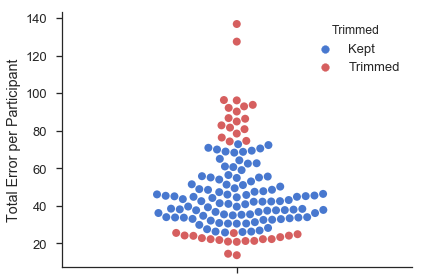

In [63]:
g=sns.swarmplot(x=[""]*len(df), y=df['Total_Error'],
                hue=df['Trimmed'], size=8, palette=[pal[0],pal[2]])
sns.despine()
g.set(ylabel='Total Error per Participant')

plt.tight_layout()
plt.savefig('../output/03Btrim.png', dpi = 300)

## Reshaping Data

The dataset will now be unpivoted into a "long" format. This means that each observation is not on a per user basis, but on a *per answer* basis. This is necessary to have the data sub divided into smaller slices to make comparisons between each chart type.

In [12]:
# The melt function is the same as unpivoting or converting to long form.
df_long = pd.melt(tdf, id_vars=['timestamp', 'Block'],
                  value_vars=['pie', 'donut', 'treemap', 'bar', 'stacked',
                              'funnel', 'angle1', 'angle2', 'arc1', 'arc2',
                              'area1', 'area2',],
                  var_name='charttype',
                  value_name='judgement')

# Create a label called "chart_id" to merge when combined with true values later
df_long['chart_id'] = df_long['charttype'] + df_long['Block'].apply(str)

# Combine the angle1 & angle 2 into a singular angle chart type.
# Do the same for arc and angle.
df_long['charttype'].replace(to_replace=['angle1', 'angle2',
                                         'arc1', 'arc2',
                                         'area1', 'area2'],
                             value=['angle', 'angle',
                                    'arc','arc',
                                    'area','area'],
                             method='string', inplace=True)

print('Here is a list of the chart types :',set(df_long.charttype))

Here is a list of the chart types : {'stacked', 'area', 'donut', 'treemap', 'arc', 'pie', 'angle', 'funnel', 'bar'}


Create longform of true values (tv) and merge it with long form of the dataframe

In [13]:
df_tv_long = pd.melt(df_tv, id_vars=['block'],
                     value_vars=['pie_tv','donut_tv', 'treemap_tv','bar_tv',
                                 'stacked_tv', 'funnel_tv', 'angle1_tv',
                                 'angle2_tv', 'arc1_tv', 'arc2_tv',
                                 'area1_tv', 'area2_tv'],
                     var_name='tvcharttype', value_name='trueValue')

# Remove the "_tv" suffix
df_tv_long['tvcharttype'] = df_tv_long['tvcharttype'].str[:-3]

# Add the Block number to the end of the tag
df_tv_long['chart_id'] = (df_tv_long['tvcharttype']
                          + df_tv_long['block'].apply(str))
df_tv_long.drop('block', axis=1, inplace=True)

# Merge it all together
df_long = pd.merge(df_long,df_tv_long, on='chart_id')

Now create the log mean error field:

In [14]:
# To do this we will define a function to calculate it.
def logError(error):
    # See paper for formula reasoning
    return np.log2(abs(error) + 1/8)

df_long['error'] = df_long['judgement'] - df_long['trueValue']
df_long['logError'] = df_long['error'].apply(logError)

Combine all the comments into one subset and export them as a .csv file for easy reading:

In [15]:
comments = df.comments[pd.notnull(df['comments'])]
comments.to_csv('comments.csv')

## Describe Data

Number of fields participants left blank?

In [16]:
def num_missing(x):
  return sum(x.isnull())

#Applying per column:
print ("Amount participants left blank:")
print (df.apply(num_missing, axis=0).head(9))

Amount participants left blank:
timestamp       0
age             9
gender          1
education       3
device          0
eyecolour       0
colourblind     0
learntype       0
vistools       32
dtype: int64


#### Summary statistics

In [17]:
df_long.describe()

,Block,judgement,trueValue,error,logError
count,1224.000000,1224.000000,1224.000000,1224.000000,1224.000000
mean,2.411765,30.024625,29.908742,0.115883,1.283844
std,1.079229,17.038445,16.303586,5.336672,1.521747
min,1.000000,4.000000,5.000000,-21.300000,-3.000000
25%,1.000000,16.625000,17.800000,-2.500000,0.608809
50%,2.000000,27.777778,26.900000,-0.200000,1.361241
75%,3.000000,40.000000,38.600000,2.200000,2.357552
max,4.000000,87.000000,76.600000,34.200000,5.101188


In [18]:
tdf.describe();
# (Ommitted for print version)

# Composition of sample

## Composition of sample

In this section we will plot some of the results

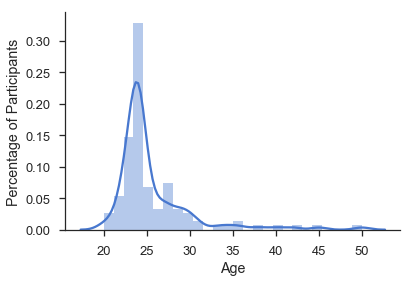

In [19]:
# This is the function that makes the graph
g = sns.distplot(df.age[df.age.notnull()], rug=False)

# This part labels the plot
g.set(xlabel='Age', ylabel='Percentage of Participants')

# This function gets rid of excess borders.
sns.despine()

# This saves the figure as a .png file
plt.savefig('../output/02age.png', dpi = 300)

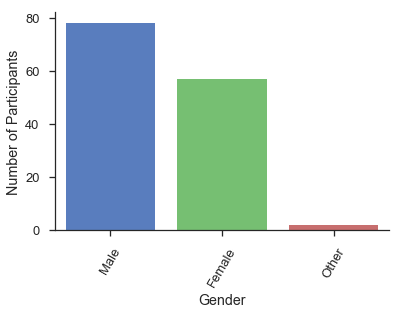

In [20]:
g = sns.countplot('gender', data=df)
g.set(xlabel='Gender', ylabel='Number of Participants')
plt.xticks(rotation=60)
sns.despine()

plt.savefig('../output/02gender.png', dpi = 300)

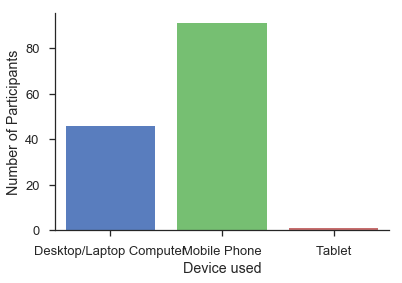

In [21]:
g = sns.countplot('device', data=df)
g.set(xlabel='Device used', ylabel='Number of Participants')
plt.xticks(rotation=0)
sns.despine()

plt.savefig('../output/02device.png', dpi = 300)

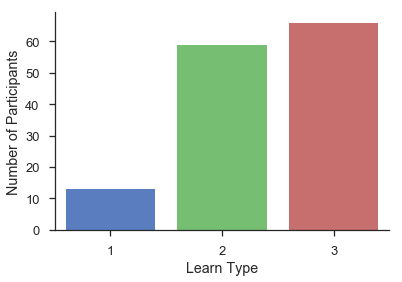

In [22]:
g = sns.countplot('learntype', data=df)
g.set(xlabel='Learn Type', ylabel='Number of Participants')
sns.despine()

Where "Other" includes:
 ['Numbers' 'Keynote - Mac' 'Osisoft pi' 'AutoCAD' 'SAP Lumira'
 'ChemDraw (similar)' 'GoodNotes4' 'Paper' 'Graphpad Prism' 'Paint'
 'SAP Predictive Analytics' 'Gaussian (computational chemistry)' 'SPSS'
 'Pages' 'Qlik view / Qlik Sense' 'Photoshop' 'Prezi' 'SCSS' 'Visio'
 'Origin' 'Lumion' 'Procreate']


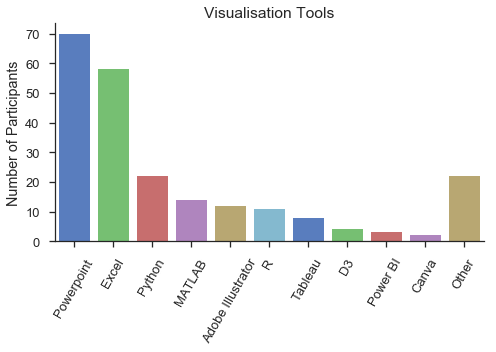

In [23]:
# These tidy up the data visualisation column, sorting out the different
# categories and removing the NA values
vistools = pd.DataFrame(df.vistools[df.vistools.notnull()]
                        .str.split(pat=',', expand=True))
vistools = pd.melt(vistools, value_name='tool')
vistools = vistools.drop(['variable'], axis=1)
vistools = vistools.dropna()
vistools['tool'] = vistools['tool'].str.strip()

# Creating the "unusual tools" which were tools with only individuals using them
unusual_tools = (vistools['tool']
                 .value_counts()[vistools['tool']
                                 .value_counts() < 2]
                 .index.values)
vistools['tool'].replace(unusual_tools, 'Other', inplace=True)
plt.figure(figsize=(7,5))

g = sns.countplot(x = 'tool', data = vistools, palette='muted',
              order = ['Powerpoint', 'Excel', 'Python', 'MATLAB',
                       'Adobe Illustrator', 'R', 'Tableau', 'D3',
                       'Power BI', 'Canva', 'Other'])

g.set(title='Visualisation Tools', ylabel='Number of Participants', xlabel='')
plt.xticks(rotation=60)
sns.despine()
plt.tight_layout()

# Printing a list of all the "unusual tools"
print('Where \"Other\" includes:\n',unusual_tools)


plt.savefig('../output/02tools.png', dpi = 300)

In [24]:
len(vistools[vistools['tool'].isin(['Excel'])])

58

In [25]:
cb = 100*float('%.4f'%(sum(df.colourblind!='No')/sum(df.colourblind.notnull())))

print((sum(df.colourblind!='No')),\
      'people (',cb,'%) of participants were colourlbind')

5 people ( 3.62 %) of participants were colourlbind


## Comparison to Irish population

The first step is to read in the census data.

In [26]:
sex = pd.read_csv('censusData/sex.csv')
edu = pd.read_csv('censusData/education.csv')
age = pd.read_csv('censusData/age.csv')


samplesex = pd.DataFrame(df['gender']
                         .value_counts()/len(df.gender[pd.notnull(df.gender)]))
samplesex.reset_index(inplace = True)
samplesex.drop([2], inplace=True)

sampleedu = pd.DataFrame(df['education']
                         .value_counts()/len(df.education[pd.notnull(df.education)]))
sampleedu.reset_index(inplace = True)
sampleedu.drop([5], inplace=True)

It is a little more complicated to transform the survey age data becuase it must be sorted into the binned format given by the census data

In [27]:
# Create the bins
bins = [5, 13, 19, 25, 35, 45, 55, 65, 75]

# Create a for loop to sum up the amount of participants who fell into each bin
# I.e. Sum up all the values between each bin boundary
binnedage = []
xold = 0
for x in bins:
    binnedage.append(len(df.age[df.age > xold][df.age < x]))
    xold=x
binnedage.append(0)
    
# Convert this list into a dataframe, label the bins
binnedage = pd.DataFrame(binnedage)
binnedage.columns = ['number']
binnedage['age'] = age['age']

# and then normalise it by dividing by the people who gave their age
binnedage['percent'] = binnedage.number/len(df.age[pd.notnull(df.age)])

### Visualise comparisons

For Education:

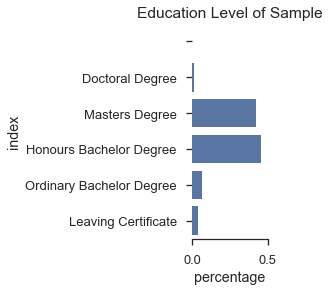

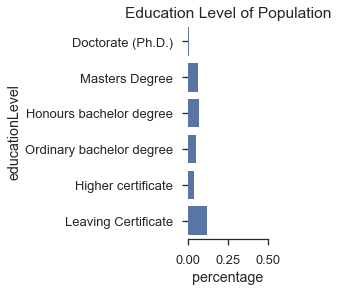

In [28]:
sampleedu = sampleedu.reindex([3,2,0,1,4])
g = sns.factorplot(x="education", y="index", data=sampleedu,
                   kind="bar", aspect =1, color="#4c72b0")
g.set(title='Education Level of Sample', xlabel='percentage')
plt.xlim(xmax=0.5)
g.fig.axes[0].invert_yaxis()
sns.despine(right=True, left=True)
plt.savefig('../output/02Bedu1.png', dpi = 300)


g = sns.factorplot(x="percentage", y="educationLevel", data=edu,
                   kind="bar", aspect =1, color="#4c72b0")
g.set(title='Education Level of Population')
plt.xlim(xmax=0.5)
g.fig.axes[0].invert_yaxis()
sns.despine(right=True, left=True)
plt.savefig('../output/02Bedu2.png', dpi = 300)

plt.show()

For gender:

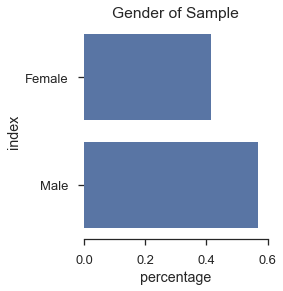

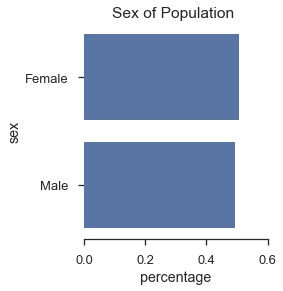

In [29]:
g = sns.factorplot(x="gender", y="index", data=samplesex,
                   kind="bar", aspect =1, color="#4c72b0")
plt.xlim(xmax=0.6)
g.set(title='Gender of Sample', xlabel='percentage')
g.fig.axes[0].invert_yaxis()
sns.despine(right=True, left=True)
plt.savefig('../output/02Bsex1.png', dpi = 300)

g = sns.factorplot(x="percentage", y="sex", data=sex,
                   kind="bar", aspect =1, color="#4c72b0")
plt.xlim(xmax=0.6)
g.set(title='Sex of Population ', xlabel='percentage')
g.fig.axes[0].invert_yaxis()
sns.despine(right=True, left=True)
plt.savefig('../output/02Bsex2.png', dpi = 300)

For Age:

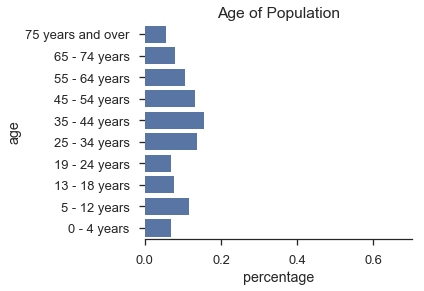

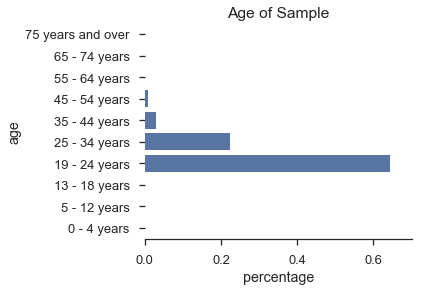

In [30]:
g = sns.factorplot(x="percent", y="age", data=age,
                   kind="bar", color="#4c72b0", aspect =1.5)
plt.xlim(xmax=0.7)
g.set(title='Age of Population', xlabel='percentage')
g.fig.axes[0].invert_yaxis()
sns.despine(right=True, left=True)
plt.savefig('../output/02Bage1.png', dpi = 300)

g = sns.factorplot(x="percent", y="age", data=binnedage,
                   kind="bar", color="#4c72b0", aspect =1.5)
plt.xlim(xmax=0.7)
g.set(title='Age of Sample', xlabel='percentage')
g.fig.axes[0].invert_yaxis()
sns.despine(right=True, left=True)
plt.savefig('../output/02Bage2.png', dpi = 300)

(Graphs post processed in PhotoShop.)

# Main Analysis

## Check consistency across blocks

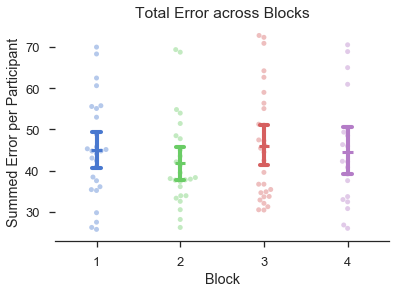

In [31]:
g=sns.swarmplot(x="Block", y="Total_Error", data=tdf, alpha=0.4)
g=sns.pointplot(x="Block", y="Total_Error", data=tdf, join=False,
                size=8, ci=95, palette='muted', capsize=0.1, markers='_')
sns.despine(left=True)
g.set(title='Total Error across Blocks', xlabel='Block',
      ylabel='Summed Error per Participant')


plt.savefig('../output/03blocking.png', dpi = 300)

Further investigate error across different charts on a per block basis

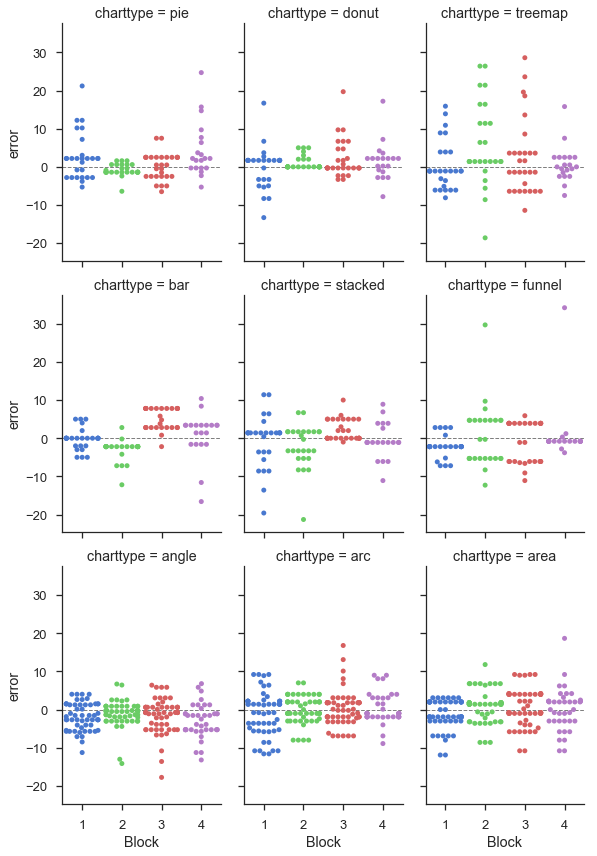

In [32]:
g = sns.factorplot(x="Block", y="error",
                   col="charttype",
                   data=df_long,
                   col_wrap=3,
                   ci=95,
                   kind='swarm',
                   size=4, aspect=0.7)

# Drawing in the axis lines:
for ax in g.axes.flat:
    ax.axhline(color='k', ls='--', lw=1, alpha=0.5)

plt.savefig('../output/03blockingpergraphtrad.png', dpi = 300)

## Investigate comparison of Total Error to metadata

Look at where the trimmed datapoints lie

Mean for males: 43.97275774285715
Mean for females: 45.37121447020929
Mean for other: 35.605555555555554


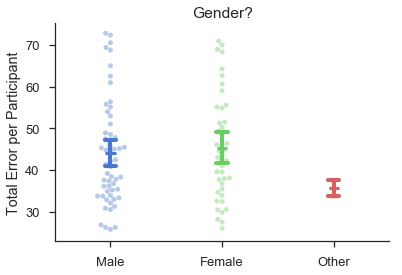

In [33]:
g=sns.swarmplot(x="gender", y="Total_Error", data=tdf, dodge=True,
                alpha=0.4)
g=sns.pointplot(x="gender", y="Total_Error", data=tdf, join=False, ci=95,
                palette='muted', capsize=0.1, markers='_')

sns.despine()
g.set(title='Gender?', xlabel='', ylabel='Total Error per Participant')


plt.savefig('../output/03Bgender.png', dpi = 300)

print('Mean for males:',tdf[tdf['gender'].isin(['Male'])]['Total_Error'].mean())
print('Mean for females:',tdf[tdf['gender'].isin(['Female'])]['Total_Error'].mean())
print('Mean for other:',tdf[tdf['gender'].isin(['Other'])]['Total_Error'].mean())

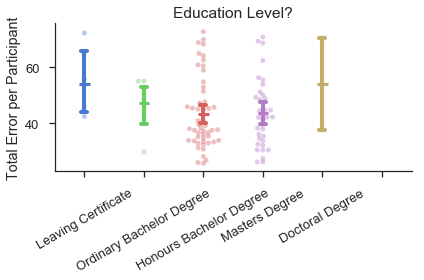

In [34]:
g=sns.swarmplot(x="education", y="Total_Error", data=tdf, dodge=True,
                alpha=0.4)
g=sns.pointplot(x="education", y="Total_Error", data=tdf, join=False,
                ci=95, palette='muted', capsize=0.1, markers='_')

plt.xticks(rotation=30)
sns.despine()
g.set(title='Education Level?', xlabel='',ylabel='Total Error per Participant')
plt.tight_layout()


plt.savefig('../output/03Beducation.png', dpi = 300)

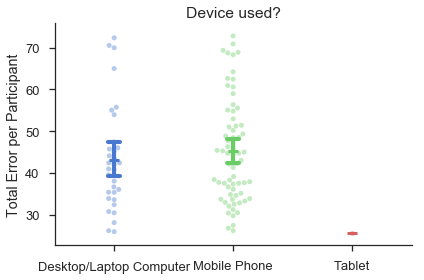

In [35]:
g=sns.swarmplot(x="device", y="Total_Error", data=tdf,
                dodge=True, alpha=0.4)
g=sns.pointplot(x="device", y="Total_Error", data=tdf, join=False,
                ci=95, palette='muted', capsize=0.1, markers='_')
sns.despine()
g.set(title='Device used?',xlabel='', ylabel='Total Error per Participant')
plt.tight_layout()

plt.savefig('../output/03Bdevice.png', dpi = 300)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


77

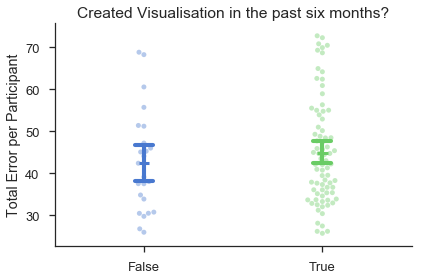

In [36]:
plotdata=tdf
plotdata['creator'] = pd.notnull(plotdata['vistools'])

g=sns.swarmplot(x="creator", y="Total_Error", data=plotdata, dodge=True,
                alpha=0.4)
g=sns.pointplot(x="creator", y="Total_Error", data=plotdata, join=False,
                ci=95, palette='muted', capsize=0.1, markers='_')
sns.despine()

g.set(title='Created Visualisation in the past six months?', xlabel='',
      ylabel='Total Error per Participant')

plt.tight_layout()

plt.savefig('../output/03Bcreator.png', dpi = 300)

len(tdf[pd.notnull(tdf['vistools'])])

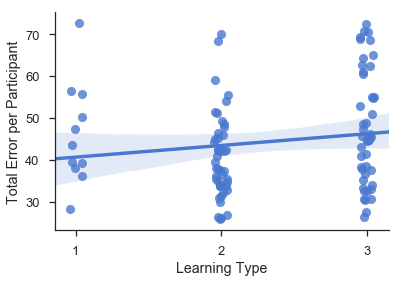

In [37]:
g=sns.regplot('learntype', 'Total_Error', data=tdf, x_jitter=0.05, ci=95)
sns.despine()
g.set(xlabel='Learning Type', ylabel='Total Error per Participant',
      xticks=[1,2,3])

plt.savefig('../output/03Blearntype.png', dpi = 300)

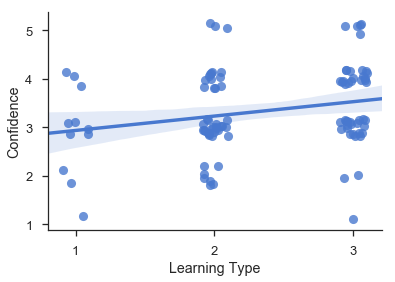

In [38]:
g=sns.regplot('learntype', 'confidence', data=tdf,
              y_jitter=0.2, x_jitter=0.1, ci=95)
sns.despine()
g.set(xlabel='Learning Type', ylabel='Confidence',
      yticks=[1,2,3,4,5], xticks=[1,2,3])

plt.savefig('../output/03Blearntypeconfidence.png', dpi = 300)

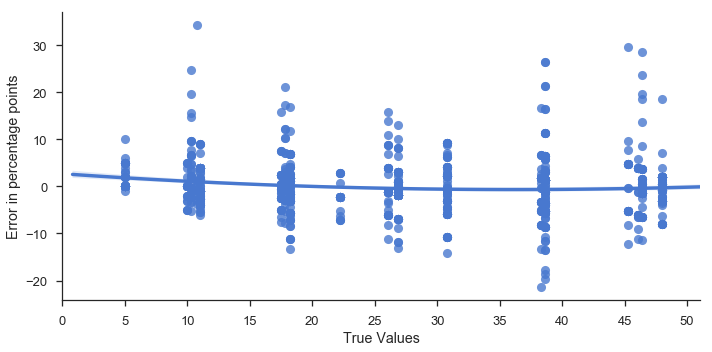

In [39]:
g=sns.lmplot(x="trueValue", y="error", data=df_long,
             ci=95, order=2, aspect=2)
plt.xlim(xmax = 51)
g.set(xlabel='True Values', ylabel='Error in percentage points',
      xticks=range(0,51,5))

sns.despine()
plt.savefig('../output/03BTrueValueVError.png', dpi = 300)

This residual distribution seems reasonably random around the y=0 axis, so a linear model is acceptable

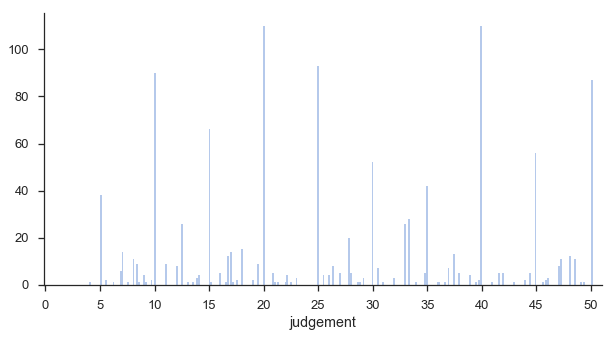

In [40]:
plotdata = df_long
plt.figure(figsize=(10,5))
g = sns.distplot(plotdata.judgement, bins=500,
                 rug=False, kde=False, norm_hist=False)
g.set(xticks=range(0,51,5))
plt.xlim(xmax=51)
sns.despine()
plt.savefig('../output/03BJudgementFrequencies.png', dpi = 300)

Let's take a look at the frequency of judgements that aren't integers:

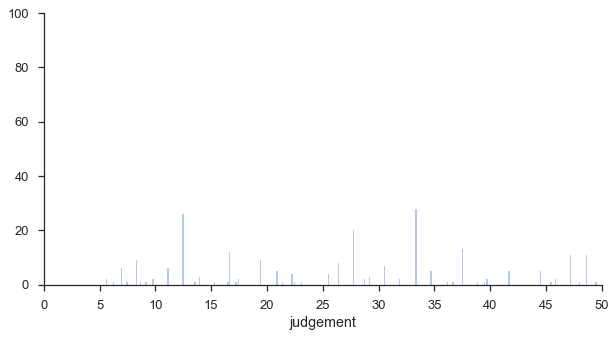

In [41]:
plotdata = df_long[df_long['judgement'].mod(1).apply(bool)]
plt.figure(figsize=(10,5))
g = sns.distplot(plotdata.judgement, bins=500,
                 rug=False, kde=False, norm_hist=False)
g.set(xticks=range(0,51,5))
plt.ylim(ymax=100)
plt.xlim(xmax=50)
sns.despine()

plt.savefig('../output/03BJudgementFrequenciesFractions.png', dpi = 300)

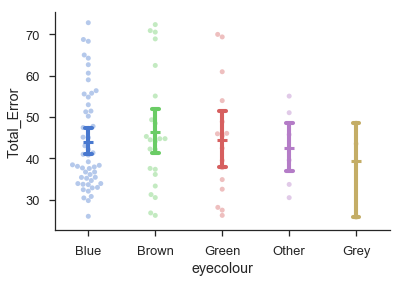

In [42]:
g.set(xlabel='Eye Colour', ylabel='Total Error per Participant')

g=sns.swarmplot(x="eyecolour", y="Total_Error", data=tdf,
                dodge=True, alpha=0.4,
                order=tdf['eyecolour'].value_counts().index)
g=sns.pointplot(x="eyecolour", y="Total_Error", data=tdf,
                join=False, ci=95, palette='muted', capsize=0.1, markers='_',
                order=tdf['eyecolour'].value_counts().index)

sns.despine()

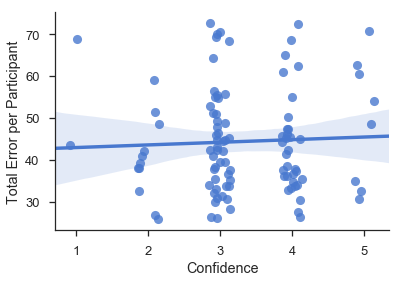

In [43]:
g=sns.regplot('confidence', 'Total_Error', data=tdf,
              x_jitter=0.15, ci=95)
sns.despine()
g.set(xlabel='Confidence', ylabel='Total Error per Participant',
      xticks=[1,2,3,4,5])


plt.savefig('../output/03Bconfidence.png', dpi = 300)

Confidence didn't appear to have much correlation with how well participants did, could there be some other factors that influence confidence?

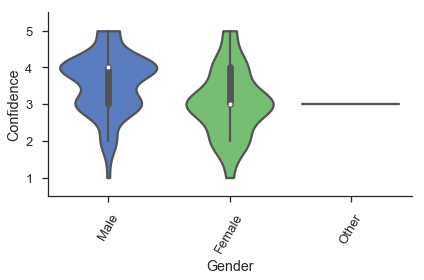

In [44]:
g =sns.violinplot(x="gender", y="confidence", data=df, dodge=False, cut=0)
plt.xticks(rotation=60)
sns.despine()
plt.ylim(ymax=5.5, ymin=0.5)
g.set(xlabel='Gender', ylabel='Confidence')
plt.tight_layout()

plt.savefig('../output/03Bgenderconfidence.png', dpi = 300)

## Scenario Selection

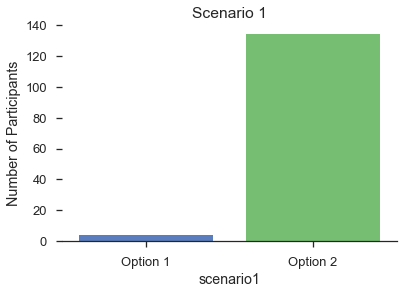

In [45]:
g = sns.countplot('scenario1', data=df, order=['Option 1', 'Option 2'])
g.set(title='Scenario 1', ylabel='Number of Participants')
sns.despine(right=True, left=True)

plt.savefig('../output/03Cscenario1.png', dpi = 300)

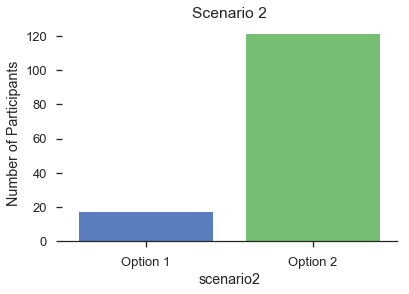

In [46]:
g = sns.countplot('scenario2', data=df, order=['Option 1', 'Option 2'])
g.set(title='Scenario 2', ylabel='Number of Participants')
sns.despine(right=True, left=True)

plt.savefig('../output/03Cscenario2.png', dpi = 300)

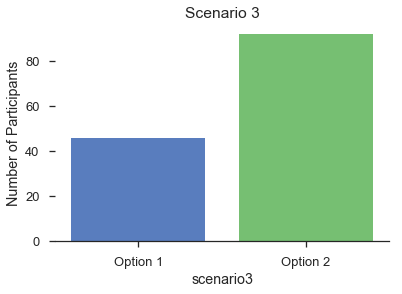

In [47]:
g = sns.countplot('scenario3', data=df, order=['Option 1', 'Option 2'])
g.set(title='Scenario 3', ylabel='Number of Participants')
sns.despine(right=True, left=True)

plt.savefig('../output/03Cscenario3.png', dpi = 300)

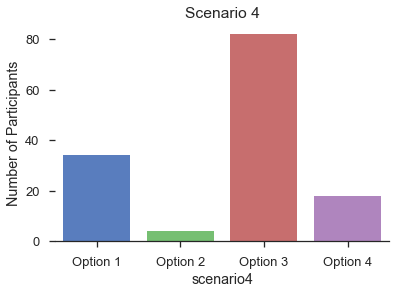

In [48]:
g = sns.countplot('scenario4', data=df,
                  order=['Option 1', 'Option 2', 'Option 3', 'Option 4'])
g.set(title='Scenario 4', ylabel='Number of Participants')
sns.despine(right=True, left=True)


plt.savefig('../output/03Cscenario4.png', dpi = 300)

## Investigate how each graph performed

In [49]:
# Create function to calculate the interquartile mean
def iqm(x):
    return scipy.stats.trim_mean(x, .25)

First plot the error

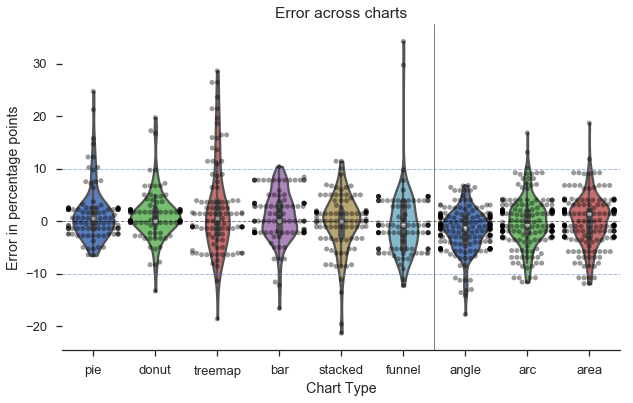

In [50]:
plt.figure(figsize=(10,6))

g = sns.violinplot(x="charttype", y="error", data=df_long,
                   cut=0, palette='muted')
g = sns.swarmplot(x="charttype", y="error", data=df_long,
                  alpha=0.4, color ='k')

g.set(title='Error across charts',
      ylabel='Error in percentage points', xlabel='Chart Type')

# Plot lines
plt.axhline(color='k', ls='--', lw=1, alpha=0.5)
plt.axvline(x = 5.5, color='k', lw=1, alpha=0.5)
plt.axhline(y= +10, color=pal[0], ls='--', lw=1, alpha=0.5)
plt.axhline(y= -10, color=pal[0], ls='--', lw=1, alpha=0.5)

sns.despine(left=True)

plt.savefig('../output/03Dcharttypeerror.png', dpi = 300)

Then taking a magnified view:

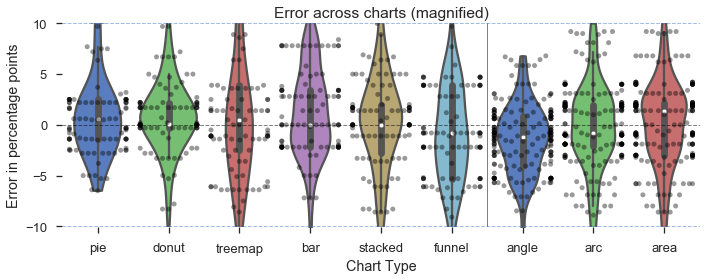

In [64]:
plt.figure(figsize=(10,4))

g = sns.violinplot(x="charttype", y="error", data=df_long,
                   cut=0, palette='muted')
g = sns.swarmplot(x="charttype", y="error", data=df_long,
                  alpha=0.4, color ='k')

g.set(title='Error across charts (magnified)',
      ylabel='Error in percentage points', xlabel='Chart Type')

# Plot lines
plt.axhline(color='k', ls='--', lw=1, alpha=0.5)
plt.axvline(x = 5.5, color='k', lw=1, alpha=0.5)
plt.axhline(y= +10, color=pal[0], ls='--', lw=1, alpha=0.5)
plt.axhline(y= -10, color=pal[0], ls='--', lw=1, alpha=0.5)

sns.despine(left=True, bottom=True)
plt.ylim(ymin=-10.1, ymax=10)
plt.tight_layout()

plt.savefig('../output/03Dcharttypeerrorzoom.png', dpi = 300)

And now plotting the log error

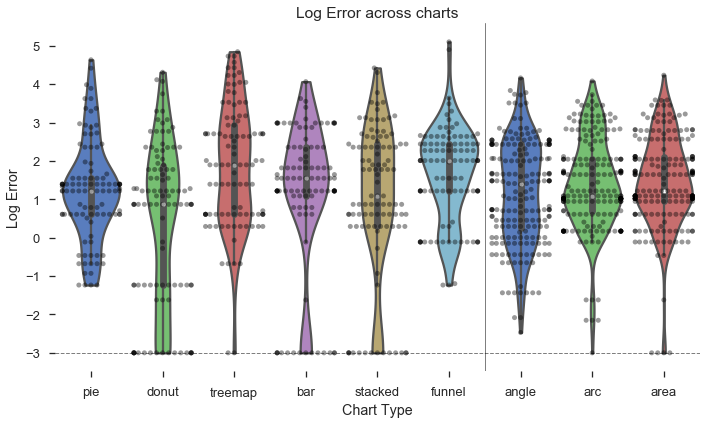

In [65]:
plt.figure(figsize=(10,6))
g = sns.violinplot(x="charttype", y="logError", data=df_long,
                   cut=0, palette='muted')
g = sns.swarmplot(x="charttype", y="logError", data=df_long,
                  alpha=0.4, color ='k')

g.set(title='Log Error across charts',
      ylabel='Log Error', xlabel='Chart Type'
     )

# Plot lines
plt.axhline(y = -3, color='k', ls='--', lw=1, alpha=0.5)
plt.axvline(x = 5.5, color='k', lw=1, alpha=0.5)

g.set(yticks=[-3,-2,-1,0,1,2,3,4,5])
sns.despine(left=True, bottom=True)
plt.tight_layout()

plt.savefig('../output/03Dcharttypelog.png', dpi = 300)

And finally, looking at the log mean log error as per the literature

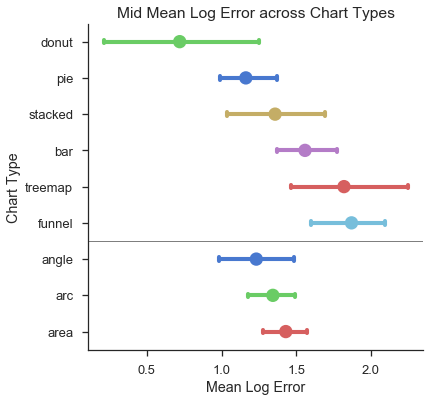

In [53]:
plotdata = df_long

plt.figure(figsize=(6, 6))
g = sns.pointplot(y='charttype', x='logError', data=plotdata,
                  ci=95, join=False, capsize=.1, estimator=iqm,
                  order = ['donut','pie', 'stacked', 'bar',
                           'treemap','funnel','angle','arc','area'],
                  palette=[pal[1],pal[0],pal[4],pal[3],
                           pal[2],pal[5],pal[0],pal[1],pal[2]]
                  )

g.set(title='Mid Mean Log Error across Chart Types',
      xlabel='Mean Log Error', ylabel='Chart Type'
     )

plt.axhline(y = 5.5, color='k', lw=1, alpha=0.5)
sns.despine()

plt.savefig('../output/03Dcharttypetradpoint.png', dpi = 300)

Let's take another look at the blocking

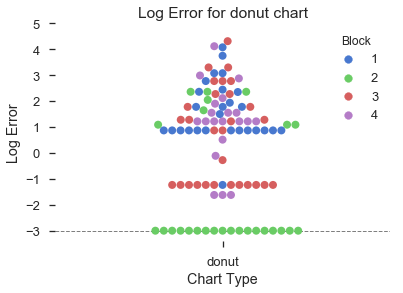

In [54]:
plotdata = df_long[df_long['charttype'].isin(['donut'])]

g = sns.swarmplot(x="charttype", y="logError", data=plotdata,
                  hue='Block', size=8)

g.set(title='Log Error for donut chart',
      ylabel='Log Error', xlabel='Chart Type'
     )

# Plot lines
plt.axhline(y = -3, color='k', ls='--', lw=1, alpha=0.5)

g.set(yticks=[-3,-2,-1,0,1,2,3,4,5])
sns.despine(left=True, bottom=True)

plt.savefig('../output/03Dcharttypelogdonut.png', dpi = 300)

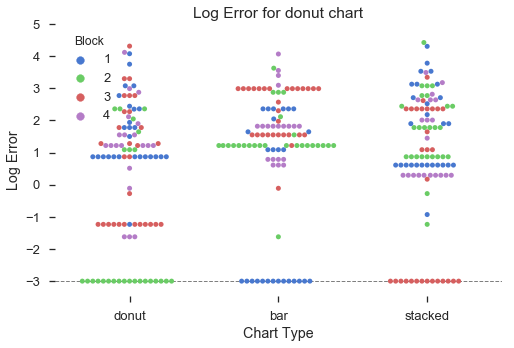

In [55]:
plotdata = df_long[df_long['charttype'].isin(['donut','bar','stacked'])]


plt.figure(figsize=(8, 5))
g = sns.swarmplot(x="charttype", y="logError", data=plotdata, hue='Block')

g.set(title='Log Error for donut chart',
      ylabel='Log Error', xlabel='Chart Type'
     )

# Plot lines
plt.axhline(y = -3, color='k', ls='--', lw=1, alpha=0.5)

g.set(yticks=[-3,-2,-1,0,1,2,3,4,5])
sns.despine(left=True, bottom=True)

plt.savefig('../output/03Dcharttypelogdonut.png', dpi = 300)

# End of main experiment

## Anscombe's Quartet

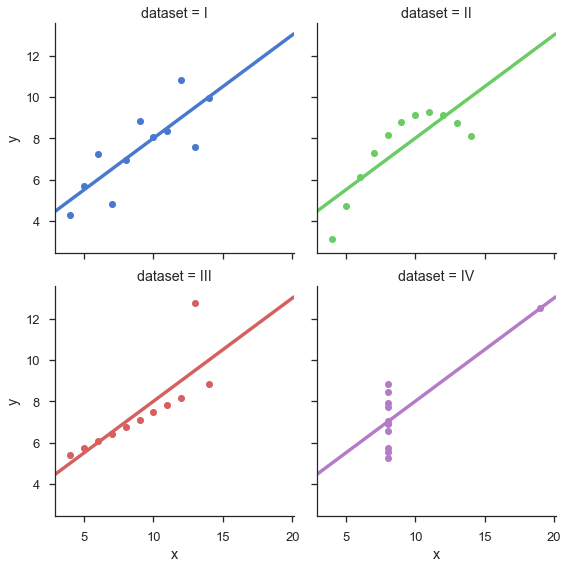

In [56]:
# Load the example dataset for Anscombe's quartet
df_anscombe = sns.load_dataset("anscombe")

# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=df_anscombe,
           col_wrap=2, ci=None, size=4,
           scatter_kws={"s": 50, "alpha": 1})

plt.savefig('../output/99Anscombe.png', dpi = 300)

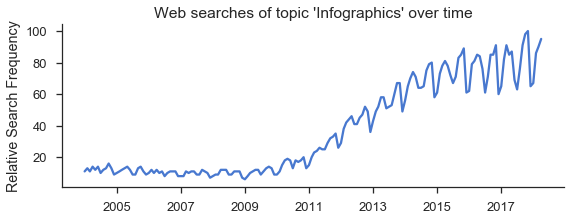

In [57]:
searchStats = pd.read_csv('multiTimeline.csv')
searchStats['Month'] = pd.to_datetime(searchStats['Month'])
searchStats

plt.figure(figsize=(9, 3))
g = plt.plot_date(x=searchStats['Month'],
                  y=searchStats['Infographic: (Worldwide)'],
                  ls='-', marker='', color=pal[0])
g = sns.despine()
plt.title('Web searches of topic \'Infographics\' over time')
plt.ylabel('Relative Search Frequency')

plt.savefig('../output/99searchStats.png', dpi = 300)

## Journal Survey

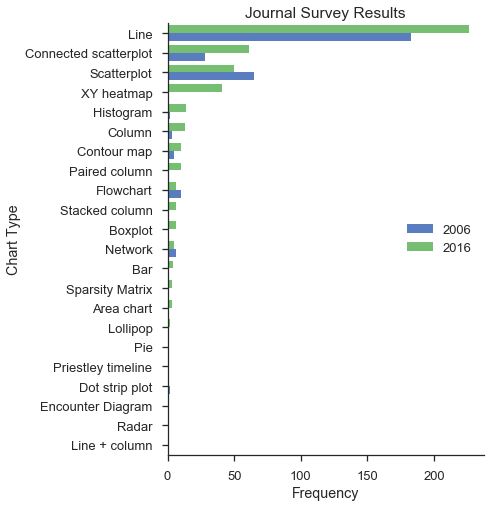

In [58]:
journalSurvey = pd.melt(pd.read_csv('journalSurvey.csv'),id_vars='chartType',
                        value_vars=['2006','2016'], var_name='year')

g = sns.factorplot(x = 'value', y='chartType', hue='year', data=journalSurvey,
                   kind = 'bar', size=7, aspect=1,legend_out=False)
g.fig.axes[0].invert_yaxis()
g.ax.legend(loc=5)
sns.despine()
g.set(title='Journal Survey Results', xlabel='Frequency', ylabel='Chart Type')

plt.savefig('../output/99journalSurvey.png', dpi = 300)

## Example plots

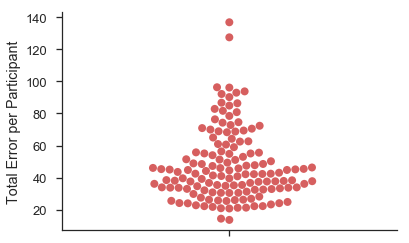

In [59]:
g=sns.swarmplot(x=[""]*len(df), y=df['Total_Error'],
                size=8, palette=[pal[2]])
sns.despine()
g.set(ylabel='Total Error per Participant')

plt.savefig('../output/00Example.png', dpi = 300)

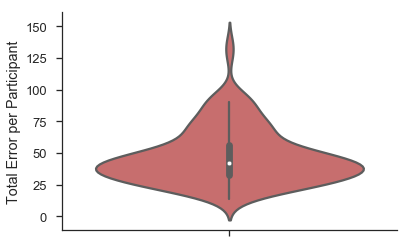

In [60]:
g=sns.violinplot(x=[""]*len(df), y=df['Total_Error'],
                size=8, palette=[pal[2]])
sns.despine()
g.set(ylabel='Total Error per Participant')

plt.savefig('../output/00Example2.png', dpi = 300)

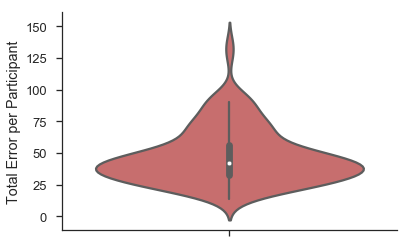

In [61]:
g=sns.violinplot(x=[""]*len(df), y=df['Total_Error'],
                size=8, palette=[pal[2]])
g=sns.swarmplot(x=[""]*len(df), y=df['Total_Error'],
                size=8, color='k', alpha=0.)

sns.despine()
g.set(ylabel='Total Error per Participant')

plt.savefig('../output/00Example3.png', dpi = 300)